In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import distance
from sklearn.decomposition import PCA
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

sys.path.extend(['/home/lindenmp/research_projects/nct_xr'])
sys.path.extend(['/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend(['/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, paired_line_plot, null_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from nctpy.metrics import ave_control
from snaplab_tools.utils import get_null_p
from nctpy.utils import normalize_state, matrix_normalization
from src.utils import get_random_partial_control_set

from brainsmash.mapgen.base import Base
from src.utils import get_adj_weights

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
# which_data = 'MICS'
# which_data = 'mouse'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if which_data == 'mouse':
    atlas = 'cortex'

if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100
elif atlas == 'cortex':
    n_parcels = 43

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


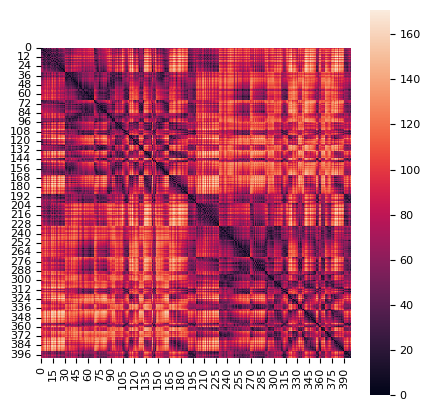

In [3]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
if which_data == 'HCPYA' or which_data == 'MICS':
    parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
    parc_centroids.drop(columns=['ROI Label'], inplace=True)
    print(parc_centroids.head())

if which_data != 'mouse':
    distance_matrix = distance.pdist(
        parc_centroids, "euclidean"
    )  # get euclidean distances between nodes
    distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix
    
    f, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(distance_matrix, ax=ax, square=True)
    plt.show()

In [4]:
file_prefix = '{0}-{1}-Am_optimal-'.format(which_data, atlas)

if which_data == 'HCPYA':
    n_states = 7
elif which_data == 'MICS':
    n_states = 5
elif which_data == 'mouse':
    n_states = 6

c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                            n_states, 
                                                                                                                                                            c, time_horizon, rho,
                                                                                                                                                            reference_state, init_weights,
                                                                                                                                                            n_steps, lr, eig_weight, reg_weight, reg_type)
print(file_str)
log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()
# log_args = np.load(os.path.join(outdir, 'multi', file_str + '.npy'), allow_pickle=True).item()

control_energy_static_decay = log_args['control_energy_static_decay']
control_energy_variable_decay = log_args['control_energy_variable_decay']

print(log_args.keys())
print(control_energy_static_decay.shape, control_energy_variable_decay.shape)

HCPYA-Schaefer4007-Am_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2
dict_keys(['state_trajectory', 'control_signals', 'numerical_error', 'control_energy', 'loss', 'eigen_values', 'optimized_weights', 'state_trajectory_variable_decay', 'control_signals_variable_decay', 'numerical_error_variable_decay', 'control_energy_variable_decay', 'state_trajectory_static_decay', 'numerical_error_static_decay', 'control_energy_static_decay', 'control_signals_corr_partial', 'control_energy_partial', 'numerical_error_partial', 'xfcorr_partial', 'control_signals_corr_partial_variable_decay', 'control_energy_partial_variable_decay', 'numerical_error_partial_variable_decay', 'xfcorr_partial_variable_decay'])
(7, 7) (7, 7)


In [5]:
# load rsfMRI clusters
k = n_states
if which_data == 'mouse':
    fmri_clusters = np.load(os.path.join(indir, 'mouse_cortex_brain_states.npy'), allow_pickle=True).item()
else:
    fmri_clusters_file = '{0}_{1}_rsts_fmri_clusters_k-{2}.npy'.format(which_data, atlas, k)
    fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()

print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']
n_states = centroids.shape[0]
n_nodes = centroids.shape[1]
n_transitions = n_states * n_states

print('n_states, {0}; n_nodes, {1}'.format(n_states, n_nodes))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_nodes, 400


## Load nulls

In [6]:
run_null = False

In [7]:
if run_null is True:
    n_perms = 5000
    if which_data == 'mouse':
        nulls = ['topology_null',]
    else:
        nulls = ['topology_null', 'brainsmash_null']
    n_nulls = len(nulls)

    control_energy_variable_decay_null = np.zeros((n_nulls, n_states, n_states, n_perms))
    control_energy_static_decay_null = np.zeros((n_nulls, n_states, n_states, n_perms))
    for n, which_null in enumerate(nulls):
        print(which_null)
        nulldir = os.path.join(outdir, which_null)

        for i in tqdm(np.arange(n_perms)):
            if which_null == 'topology_null':
                if which_data == 'mouse':
                    file_prefix_null = '{0}-Am-wwp-adj-{1}'.format(which_data.lower(), i)
                else:
                    file_prefix_null = '{0}-Am-wsp-adj-{1}'.format(which_data.lower(), i)
            elif which_null == 'brainsmash_null':
                file_prefix_null = '{0}-Am_surr-target-{1}'.format(which_data.lower(), i)


            file_str = '{0}_optimal-optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix_null, 
                                                                                                                                                                    n_states, 
                                                                                                                                                                    c, time_horizon, rho,
                                                                                                                                                                    reference_state, init_weights,
                                                                                                                                                                    n_steps, lr, eig_weight, reg_weight, reg_type)
            if i == 0:
                print(file_str)

            log_args_null = np.load(os.path.join(nulldir, file_str + '.npy'), allow_pickle=True).item()
            control_energy_variable_decay_null[n, :, :, i] = log_args_null['control_energy_variable_decay']
            control_energy_static_decay_null[n, :, :, i] = log_args_null['control_energy_static_decay']

        print(np.any(np.isinf(control_energy_variable_decay_null)), np.any(np.isnan(control_energy_variable_decay_null)))

# Control energy

In [8]:
dt = 0.001

In [9]:
mask = np.zeros((n_states, n_states)).astype(bool)
mask[np.eye(n_states) == 1] = True
mask

array([[ True, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False],
       [False, False,  True, False, False, False, False],
       [False, False, False,  True, False, False, False],
       [False, False, False, False,  True, False, False],
       [False, False, False, False, False,  True, False],
       [False, False, False, False, False, False,  True]])

In [10]:
brain_state_corr = np.zeros((n_states, n_states))
for state_i in np.arange(n_states):
    for state_j in np.arange(n_states):
        nan_mask = np.logical_or(np.isnan(centroids[state_i, :]), np.isnan(centroids[state_j, :]))
        brain_state_corr[state_i, state_j] = sp.stats.pearsonr(centroids[state_i, ~nan_mask], centroids[state_j, ~nan_mask])[0]

744.0
TtestResult(statistic=-17.99155990518909, pvalue=4.570930412089399e-21, df=41)
0.8571428571428571


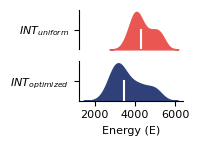

,variable,Energy (E)
0,$INT_{uniform}$,5284.451969
1,$INT_{uniform}$,5242.404209
2,$INT_{uniform}$,3860.605100
3,$INT_{uniform}$,4055.626783
4,$INT_{uniform}$,4059.096396


In [11]:
my_colors = get_my_colors(cat_trio=True, as_list=True)
df = pd.DataFrame(index=np.arange((n_states * n_states) - n_states))
df['$INT_{uniform}$'] = control_energy_static_decay[~mask]
df['$INT_{optimized}$'] = control_energy_variable_decay[~mask]
print(np.round(np.abs(df['$INT_{optimized}$'].mean() - df['$INT_{uniform}$'].mean())))
print(sp.stats.ttest_rel(df['$INT_{optimized}$'], df['$INT_{uniform}$']))
print(np.sum(df['$INT_{optimized}$'] < df['$INT_{uniform}$']) / n_transitions)
df = df.melt()
df.rename(columns={'value': 'Energy (E)'}, inplace=True)
f = categorical_kde_plot(df=df, variable='Energy (E)', category='variable', horizontal=True, color_palette=my_colors, rug=False, fig_width=2, fig_height=1.5)
f.savefig(os.path.join(outdir, 'energy_violin.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
df.head()

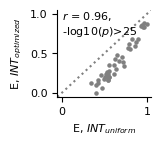

In [12]:
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

x = control_energy_static_decay[~mask]
y = control_energy_variable_decay[~mask]
data = np.concatenate((x, y))
x = (x - np.min(data)) / (np.max(data) - np.min(data))
y = (y - np.min(data)) / (np.max(data) - np.min(data))

# ax.scatter(x=x, y=y, s=5, c=brain_state_corr[~mask], cmap='coolwarm')
ax.scatter(x=x, y=y, s=5, c='grey')
ax.set_xlabel('E, $INT_{uniform}$')
ax.set_ylabel('E, $INT_{optimized}$')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
plt.axline((0, 0), slope=1, linestyle=':', color='gray')
sns.despine(ax=ax)
r, r_p = sp.stats.pearsonr(x, y)
textstr = '$\mathit{:}$ = {:.2f},\n{:}'.format('{r}', r, get_p_val_string(r_p))
# textstr = '$\mathit{:}$ = {:.2f}'.format('{r}', r)
ax.text(0.05, 1, textstr, transform=ax.transAxes, verticalalignment='top')

f.tight_layout()
f.savefig(os.path.join(outdir, 'energy_correlation_identity.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()


### Control energy: null

In [13]:
run_cells = True

In [14]:
if run_null is True:
    # get observed effect (energy delta)
    observed_delta = control_energy_variable_decay[~mask].mean() - control_energy_static_decay[~mask].mean()
    print(observed_delta)

    # n = 0
    n_nulls = len(nulls)
    for n in np.arange(n_nulls):
        print(nulls[n])

        null_delta = np.zeros((n_perms))
        for i in tqdm(np.arange(n_perms)):
            null_delta[i] = control_energy_variable_decay_null[n, :, :, i][~mask].mean() - control_energy_static_decay[~mask].mean()

        f, ax = plt.subplots(1, 1, figsize=(1, 0.25))
        p_val = get_null_p(observed_delta, null_delta, version='smallest')
        print(p_val)
        null_plot(observed_delta, null_delta, '', ax=ax, p_val=p_val, add_text=False, use_kde=True)
        ax.set_yticks([])
        ax.set_ylabel('')

        # f.tight_layout()
        f.savefig(os.path.join(outdir, 'energy_{0}.svg'.format(nulls[n])), dpi=600, bbox_inches="tight", pad_inches=0.01)
        plt.show()

### Eigenmodes and eigenvals

In [15]:
def compute_density(matrix):
    # Count total number of elements
    total_elements = matrix.size
    
    # Count number of non-zero elements
    nonzero_elements = np.count_nonzero(matrix)
    
    # Calculate percentage of non-zero elements
    nonzero_percentage = (nonzero_elements / total_elements) * 100
    
    return np.round(nonzero_percentage).astype(int)

In [16]:
system = 'continuous'
adjacency = np.load(os.path.join(indir, '{0}_{1}_Am.npy'.format(which_data, atlas)))
adjacency_norm = matrix_normalization(adjacency, system=system)

# eigenvalues_norm, eigenvectors_norm = np.linalg.eig(adjacency_norm)
# idx = np.argsort(np.abs(eigenvalues_norm))[::-1]
# sorted_eigenvalues_norm = eigenvalues_norm[idx]
# sorted_eigenvectors_norm = eigenvectors_norm[:, idx]

adjacency_weights = get_adj_weights(log_args, subtract_one=True)
adjacency_norm = matrix_normalization(adjacency, system=system)
print(adjacency_weights.shape)

# thr = 2
thr = 0.005

sorted_eigenvalues_norm = []
eigenvectors_norm_density = []
sorted_eigenvalues_norm_opt = []
eigenvectors_norm_opt_density = []
for initial_idx in tqdm(np.arange(n_states)):
    for target_idx in np.arange(n_states):
        if initial_idx != target_idx:
            adjacency_norm_opt = adjacency_norm.copy()
            adjacency_norm_opt[np.eye(n_nodes) == 1] = np.mean(adjacency_weights[initial_idx, target_idx])
            eigenvalues_norm_opt, eigenvectors_norm_opt = np.linalg.eig(adjacency_norm_opt)
            idx = np.argsort(np.abs(eigenvalues_norm_opt))[::-1]
            sorted_eigenvalues_norm.append(eigenvalues_norm_opt[idx])
            if initial_idx == 0 and target_idx == n_states - 1:
                sorted_eigenvectors_norm = eigenvectors_norm_opt[:, idx].copy()
            # eigenvectors_norm_density.append(compute_density(np.round(eigenvectors_norm_opt, thr)))
            eigenvectors_norm_opt[np.abs(eigenvectors_norm_opt) < thr] = 0
            eigenvectors_norm_density.append(compute_density(eigenvectors_norm_opt))

            adjacency_norm_opt = adjacency_norm.copy()
            adjacency_norm_opt[np.eye(n_nodes) == 1] = adjacency_weights[initial_idx, target_idx]
            eigenvalues_norm_opt, eigenvectors_norm_opt = np.linalg.eig(adjacency_norm_opt)
            idx = np.argsort(np.abs(eigenvalues_norm_opt))[::-1]
            sorted_eigenvalues_norm_opt.append(eigenvalues_norm_opt[idx])
            if initial_idx == 0 and target_idx == n_states - 1:
                sorted_eigenvectors_norm_opt = eigenvectors_norm_opt[:, idx].copy()
            # eigenvectors_norm_opt_density.append(compute_density(np.round(eigenvectors_norm_opt, thr)))
            eigenvectors_norm_opt[np.abs(eigenvectors_norm_opt) < thr] = 0
            eigenvectors_norm_opt_density.append(compute_density(eigenvectors_norm_opt))
            
eigenvectors_norm_density = np.asarray(eigenvectors_norm_density)
eigenvectors_norm_opt_density = np.asarray(eigenvectors_norm_opt_density)
print(eigenvectors_norm_density.shape, eigenvectors_norm_density[:5], eigenvectors_norm_density.mean())
print(eigenvectors_norm_opt_density.shape, eigenvectors_norm_opt_density[:5], eigenvectors_norm_opt_density.mean())

(7, 7, 400)


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

(42,) [92 92 92 92 92] 92.0
(42,) [58 58 43 48 47] 48.42857142857143


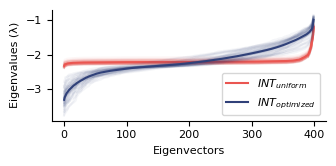

In [17]:
my_colors = get_my_colors(cat_trio=True, as_list=True)

f, ax = plt.subplots(1, 1, figsize=(3.4, 1.7))

x=np.arange(n_nodes)
for plot_data in sorted_eigenvalues_norm:
    ax.plot(x, plot_data, color=my_colors[0], alpha=0.05)
ax.plot(x, np.mean(np.asarray(sorted_eigenvalues_norm), axis=0), color=my_colors[0], alpha=1, label=r'$INT_{uniform}$')
for plot_data in sorted_eigenvalues_norm_opt:
    ax.plot(x, plot_data, color=my_colors[1], alpha=0.05)
ax.plot(x, np.mean(np.asarray(sorted_eigenvalues_norm_opt), axis=0), label=r'$INT_{optimized}$', color=my_colors[1], linewidth=1.5)
ax.set_ylabel('Eigenvalues (λ)')
ax.set_xlabel('Eigenvectors')
ax.legend()
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.tight_layout()
f.savefig(os.path.join(outdir, 'eigenmodes.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)


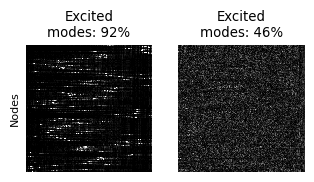

In [18]:
f, ax = plt.subplots(1, 2, figsize=(3.6, 2))

thr = 0.005
plot_data = np.abs(sorted_eigenvectors_norm).copy()
plot_data[plot_data < thr] = 0
sns.heatmap(plot_data, ax=ax[1], square=True, vmax=0.3, cbar=False, cmap='gray')
ax[0].set_title('Excited\nmodes: {0}%'.format(compute_density(plot_data)))
ax[0].set_title('Excited\nmodes: {0}%'.format(compute_density(np.round(sorted_eigenvectors_norm, 2))))

plot_data = np.abs(sorted_eigenvectors_norm_opt).copy()
plot_data[plot_data < thr] = 0
sns.heatmap(plot_data, ax=ax[0], square=True, vmax=0.3, cbar=False, cmap='gray')
ax[1].set_title('Excited\nmodes: {0}%'.format(compute_density(plot_data)))
ax[1].set_title('Excited\nmodes: {0}%'.format(compute_density(np.round(sorted_eigenvectors_norm_opt, 2))))

for this_ax in ax:
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    this_ax.set_xlabel('Eigenvectors')
    this_ax.set_xlabel('')
    # this_ax.set_ylabel('')
ax[0].set_ylabel('Nodes')
f.savefig(os.path.join(outdir, 'excited_eigenmodes.png'), dpi=600, bbox_inches="tight", pad_inches=0.01)

44.0
TtestResult(statistic=-56.32661798790583, pvalue=1.8367552246012432e-40, df=41)
0.8571428571428571


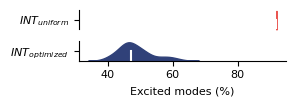

,variable,Excited modes (%)
0,$INT_{uniform}$,92.004967
1,$INT_{uniform}$,91.998617
2,$INT_{uniform}$,92.006477
3,$INT_{uniform}$,92.015230
4,$INT_{uniform}$,91.997658


In [19]:
my_colors = get_my_colors(cat_trio=True, as_list=True)
df = pd.DataFrame(index=np.arange((n_states * n_states) - n_states))
np.random.seed(42)
noise = 0 + 0.01 * np.random.randn(n_transitions - n_states)
df['$INT_{uniform}$'] = eigenvectors_norm_density + noise
df['$INT_{optimized}$'] = eigenvectors_norm_opt_density
print(np.round(np.abs(df['$INT_{optimized}$'].mean() - df['$INT_{uniform}$'].mean())))
print(sp.stats.ttest_rel(df['$INT_{optimized}$'], df['$INT_{uniform}$']))
print(np.sum(df['$INT_{optimized}$'] < df['$INT_{uniform}$']) / n_transitions)
df = df.melt()
df.rename(columns={'value': 'Excited modes (%)'}, inplace=True)
f = categorical_kde_plot(df=df, variable='Excited modes (%)', category='variable', horizontal=True, color_palette=my_colors, rug=False, fig_width=3, fig_height=1.1)
f.savefig(os.path.join(outdir, 'excited_eigenmodes_violin.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
df.head()

## Partial control set

### Partial control set: random nodes

In [20]:
run_cells = False

In [21]:
if run_cells is True:
    control_signals_corr_partial = log_args['control_signals_corr_partial']
    control_energy_partial = log_args['control_energy_partial']
    numerical_error_partial = log_args['numerical_error_partial']
    xfcorr_partial = log_args['xfcorr_partial']

    control_signals_corr_partial_variable_decay = log_args['control_signals_corr_partial_variable_decay']
    control_energy_partial_variable_decay = log_args['control_energy_partial_variable_decay']
    numerical_error_partial_variable_decay = log_args['numerical_error_partial_variable_decay']
    xfcorr_partial_variable_decay = log_args['xfcorr_partial_variable_decay']

    n_control_nodes = np.linspace(5, n_nodes-5, control_energy_partial.shape[2]).astype(int)
    print(n_control_nodes)

    legend_txt = [r'$INT_{uniform}$', r'$INT_{optimized}$']
    f, ax = plt.subplots(3, 1, figsize=(3.5, 4.5))
    # f, ax = plt.subplots(3, 1, figsize=(10, 8))
    paired_line_plot(n_control_nodes, control_energy_partial.mean(axis=0).mean(axis=0) * dt, control_energy_partial_variable_decay.mean(axis=0).mean(axis=0) * dt, legend_txt[0], legend_txt[1], ax[2], add_summary_line='median')
    ax[2].set_ylabel('Energy')
    ax[2].set_yscale('log')

    paired_line_plot(n_control_nodes, numerical_error_partial.mean(axis=0).mean(axis=0), numerical_error_partial_variable_decay.mean(axis=0).mean(axis=0), legend_txt[0], legend_txt[1], ax[1], add_summary_line='median')
    ax[1].set_ylabel('Reconstruction error')
    ax[1].set_yscale('log')
    thr = 1e-2
    ax[1].axhline(y=thr, linestyle=':', c='gray')

    paired_line_plot(n_control_nodes, xfcorr_partial.mean(axis=0).mean(axis=0), xfcorr_partial_variable_decay.mean(axis=0).mean(axis=0), legend_txt[0], legend_txt[1], ax[0], add_summary_line='median')
    vline_idx = n_control_nodes[np.where(xfcorr_partial.mean(axis=0).mean(axis=0).mean(axis=-1) > .99)[0][0]]
    print(vline_idx)
    ax[0].axvline(x=vline_idx, linestyle=':', c='gray')
    vline_idx = n_control_nodes[np.where(xfcorr_partial_variable_decay.mean(axis=0).mean(axis=0).mean(axis=-1) > .99)[0][0]]
    print(vline_idx)
    ax[0].axvline(x=vline_idx, linestyle=':', c='gray')
    ax[0].set_ylabel(r'$Pearson (x(T), x_{T})$')
    ax[0].legend()

    # for this_ax in ax:
        # this_ax.set_xlabel('number of random control nodes')
    ax[-1].set_xlabel('Number of random control nodes')

    f.tight_layout()
    f.savefig(os.path.join(outdir, 'control_energy_partial.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)


### Partial control set: new code from Jason

In [22]:
run_cells = False

In [23]:
if run_cells is True:
    adjacency_weights = get_adj_weights(log_args, subtract_one=True)
    # adjacency_weights.shape
    
    n_control_nodes = np.linspace(5, int(n_nodes/2), 25).astype(int)
    n_unique_cns = n_control_nodes.shape[0]
    n_samples = 20

    print(n_unique_cns, n_control_nodes, n_samples)

    control_energy_partial_new = np.zeros((n_states, n_states, n_unique_cns, n_samples))
    numerical_error_partial_new = np.zeros((n_states, n_states, n_unique_cns, n_samples))
    xfcorr_partial_new = np.zeros((n_states, n_states, n_unique_cns, n_samples))

    control_energy_partial_new_variable_decay = np.zeros((n_states, n_states, n_unique_cns, n_samples))
    numerical_error_partial_new_variable_decay = np.zeros((n_states, n_states, n_unique_cns, n_samples))
    xfcorr_partial_new_variable_decay = np.zeros((n_states, n_states, n_unique_cns, n_samples))
    
    def helper_func(adjacency_norm_opt):
        Wc = sp.linalg.solve_continuous_lyapunov(adjacency_norm_opt, -Q)
        E = np.sum(1 / sp.linalg.svdvals(Wc))
        final_state = np.matmul(Wc, np.linalg.solve(Wc, target_state))
        xf_error = np.linalg.norm(final_state - target_state)
        xf_corr = sp.stats.pearsonr(final_state, target_state)[0]
        
        return E, xf_error, xf_corr

    for initial_idx in np.arange(n_states):
        initial_state = normalize_state(centroids[initial_idx, :])  # initial state
        
        for target_idx in np.arange(n_states):
            target_state = normalize_state(centroids[target_idx, :])  # target state
            print('initial_state = {0}, target_state = {1}'.format(initial_idx, target_idx))
            
            for i in tqdm(np.arange(n_unique_cns)):
                for j in np.arange(n_samples):
                    B = get_random_partial_control_set(n_nodes=n_nodes, n_control_nodes=n_control_nodes[i], add_small_control=False, seed=j)
                    Q = B @ B.T
                    
                    ##############################################################################################################################################
                    adjacency_norm_opt = adjacency_norm.copy()
                    # adjacency_norm_opt[np.eye(n_nodes) == 1] = adjacency_weights[initial_idx, target_idx].mean()
                    
                    control_energy_partial_new[initial_idx, target_idx, i, j], \
                        numerical_error_partial_new[initial_idx, target_idx, i, j], \
                        xfcorr_partial_new[initial_idx, target_idx, i, j] = helper_func(adjacency_norm_opt)
                    ##############################################################################################################################################

                    ##############################################################################################################################################
                    adjacency_norm_opt = adjacency_norm.copy()
                    adjacency_norm_opt[np.eye(n_nodes) == 1] = adjacency_weights[initial_idx, target_idx]
                    
                    control_energy_partial_new_variable_decay[initial_idx, target_idx, i, j], \
                        numerical_error_partial_new_variable_decay[initial_idx, target_idx, i, j], \
                        xfcorr_partial_new_variable_decay[initial_idx, target_idx, i, j] = helper_func(adjacency_norm_opt)
                    ##############################################################################################################################################

In [24]:
if run_cells is True:
    legend_txt = [r'$INT_{uniform}$', r'$INT_{optimized}$']
    f, ax = plt.subplots(3, 1, figsize=(3.5, 4.5))
    truncate_idx = -1
    paired_line_plot(n_control_nodes[:truncate_idx],
                     control_energy_partial_new.mean(axis=0).mean(axis=0)[:truncate_idx] * dt,
                     control_energy_partial_new_variable_decay.mean(axis=0).mean(axis=0)[:truncate_idx] * dt, legend_txt[0], legend_txt[1], ax[2], add_summary_line='median')
    ax[2].set_ylabel('Energy')
    ax[2].set_yscale('log')

    paired_line_plot(n_control_nodes[:truncate_idx],
                     numerical_error_partial_new.mean(axis=0).mean(axis=0)[:truncate_idx],
                     numerical_error_partial_new_variable_decay.mean(axis=0).mean(axis=0)[:truncate_idx], legend_txt[0], legend_txt[1], ax[1], add_summary_line='median')
    ax[1].set_ylabel('Reconstruction error')
    ax[1].set_yscale('log')
    thr = 1e-2
    ax[1].axhline(y=thr, linestyle=':', c='gray')

    paired_line_plot(n_control_nodes[:truncate_idx],
                     xfcorr_partial_new.mean(axis=0).mean(axis=0)[:truncate_idx],
                     xfcorr_partial_new_variable_decay.mean(axis=0).mean(axis=0)[:truncate_idx], legend_txt[0], legend_txt[1], ax[0], add_summary_line='median')
    vline_idx = n_control_nodes[np.where(xfcorr_partial_new.mean(axis=0).mean(axis=0).mean(axis=-1) > .9)[0][0]]
    print(vline_idx)
    ax[0].axvline(x=vline_idx, linestyle=':', c='gray')
    vline_idx = n_control_nodes[np.where(xfcorr_partial_new_variable_decay.mean(axis=0).mean(axis=0).mean(axis=-1) > .9)[0][0]]
    print(vline_idx)
    ax[0].axvline(x=vline_idx, linestyle=':', c='gray')
    ax[0].set_ylabel(r'$Pearson (x(T), x_{T})$')
    # ax[0].legend()

    ax[-1].set_xlabel('Number of random control nodes (k)')

    f.tight_layout()
    f.savefig(os.path.join(outdir, 'control_energy_partial_new.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)